In [1]:
import os
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
plt.style.use('classic')
plt.rc("figure", facecolor="white")
rcParams['figure.figsize'] = 15, 6

# random seed
random_state=0
rng = np.random.RandomState(seed=random_state)

## Load data and preprocess

In [2]:
# Load the data and keep the the dates with less missing values for most houses
data_process = pd.read_csv('houses_clean.csv',parse_dates=['Time'], index_col='Time')
data = data_process.copy(deep=True)
data = data['2014-04':'2015-03']

In [3]:
# keep the house of choice for modelling
houses=[1,2,4,5,6,7,8,9,10,12,13,15,16,17,18,19,20]
house_nr = 1
drop_houses = ['House_'+str(i) for i in houses if i != house_nr]
data = data.drop(drop_houses, axis=1)

# drop nan values
data = data.dropna(axis=0,how='any')

In [4]:
data.head()

,House_1
Time,
2014-04-01 00:00:00,0.848060
2014-04-01 01:00:00,0.961215
2014-04-01 02:00:00,0.873575
2014-04-01 03:00:00,0.893387
2014-04-01 04:00:00,0.852123


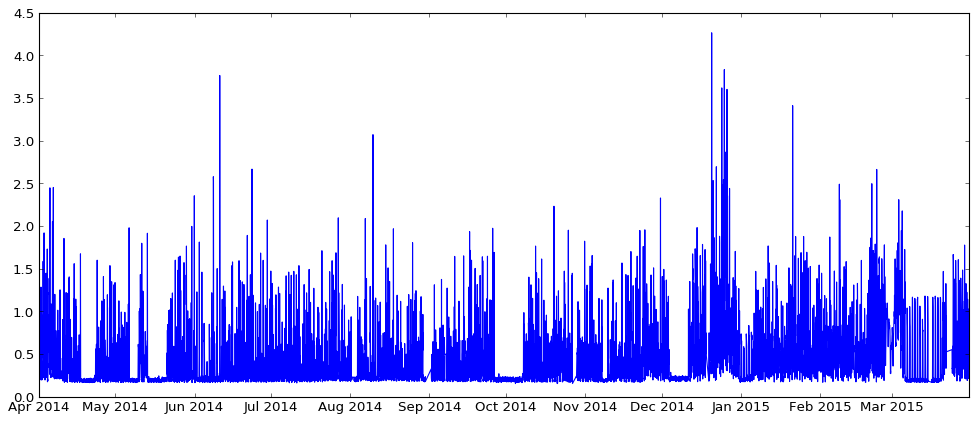

In [5]:
plt.plot(data)

## Stationarity Tests

In [5]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(center=False,window=24).mean()
    rolstd = timeseries.rolling(center=False,window=24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

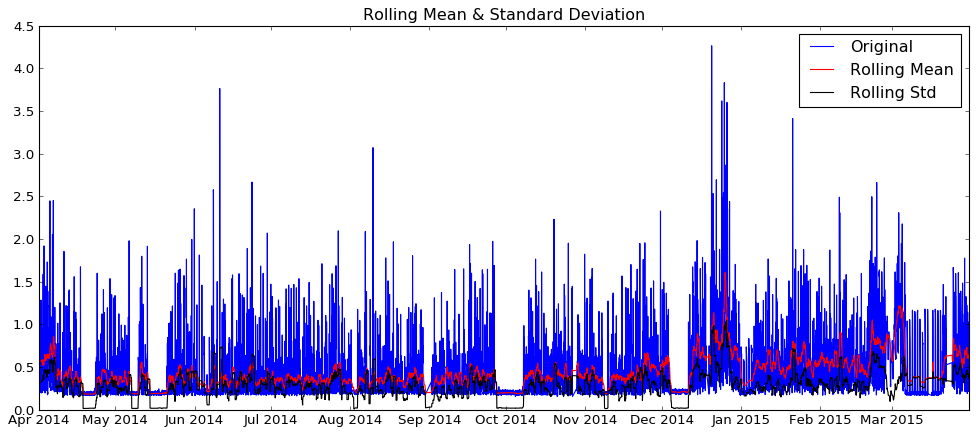

Results of Dickey-Fuller Test:
Test Statistic                -6.249855e+00
p-value                        4.481655e-08
#Lags Used                     3.200000e+01
Number of Observations Used    8.491000e+03
Critical Value (5%)           -2.861880e+00
Critical Value (10%)          -2.566951e+00
Critical Value (1%)           -3.431120e+00
dtype: float64


In [13]:
# check for stationarity
test_stationarity(data)

## ARIMA Modeling

ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1), …, x(t-5).
- Number of MA (Moving Average) terms (q): MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1), …, e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- Number of Differences (d): These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

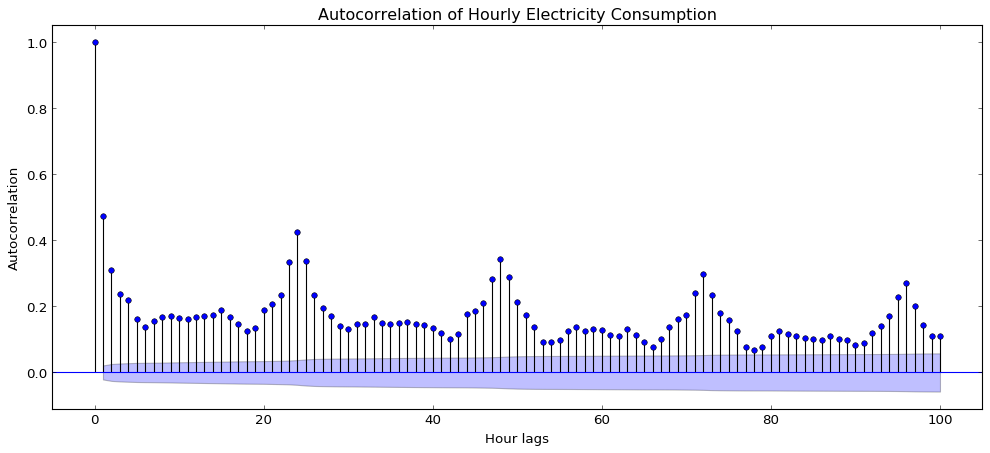

In [17]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data.House_1,lags=100)
plt.xlabel('Hour lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Hourly Electricity Consumption')
plt.show()

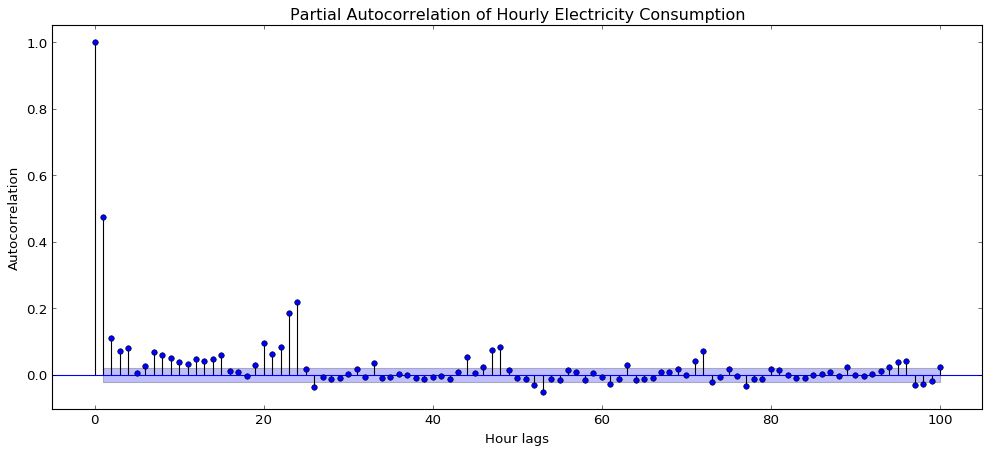

In [22]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data.House_1,lags=100)
plt.xlabel('Hour lags')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation of Hourly Electricity Consumption')
plt.show()

In [89]:
model = sm.tsa.statespace.SARIMAX(data, order=(24, 0, 1))

results = model.fit()

In [90]:
print(results.summary())

                           Statespace Model Results                           
Dep. Variable:                House_1   No. Observations:                 8524
Model:              SARIMAX(24, 0, 1)   Log Likelihood               -1667.374
Date:                Fri, 23 Jun 2017   AIC                           3386.749
Time:                        22:13:30   BIC                           3570.065
Sample:                    04-01-2014   HQIC                          3449.296
                         - 03-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3951      0.034     11.508      0.000       0.328       0.462
ar.L2          0.0273      0.015      1.823      0.068      -0.002       0.057
ar.L3          0.0093      0.011      0.862      0.3

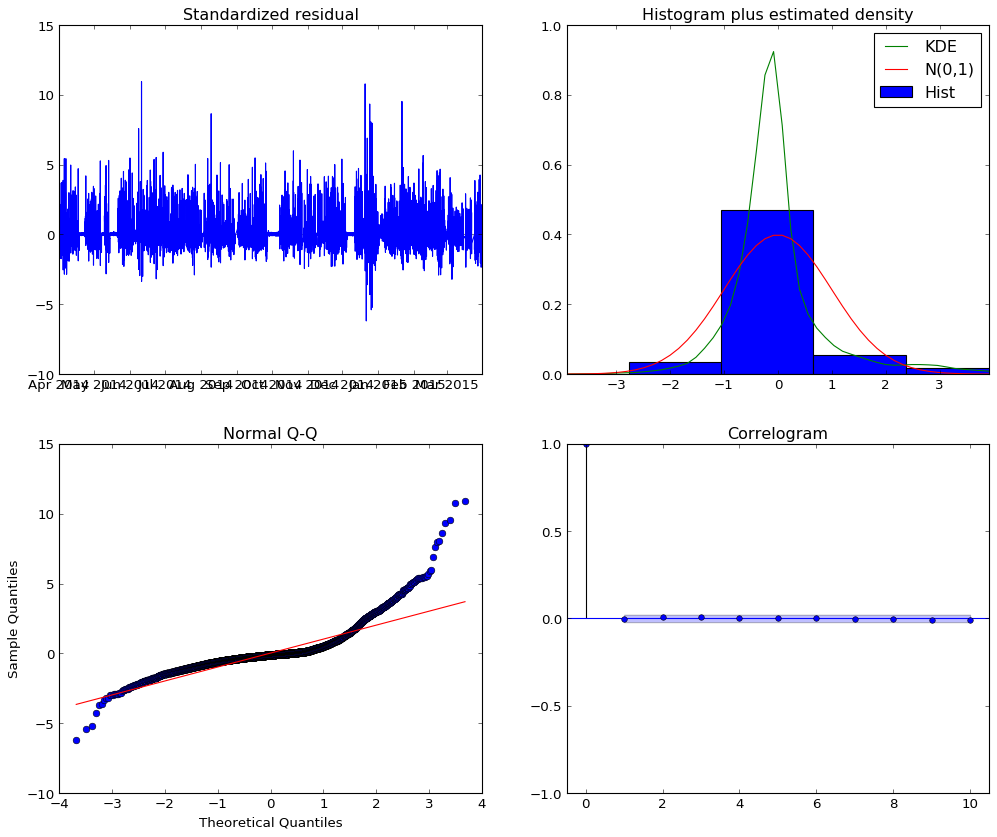

In [91]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

## ARIMA with seasonal differencing

In [6]:
data_diff =  data - data.shift(periods=24)

In [8]:
data_diff = data_diff.dropna(axis=0,how='any')

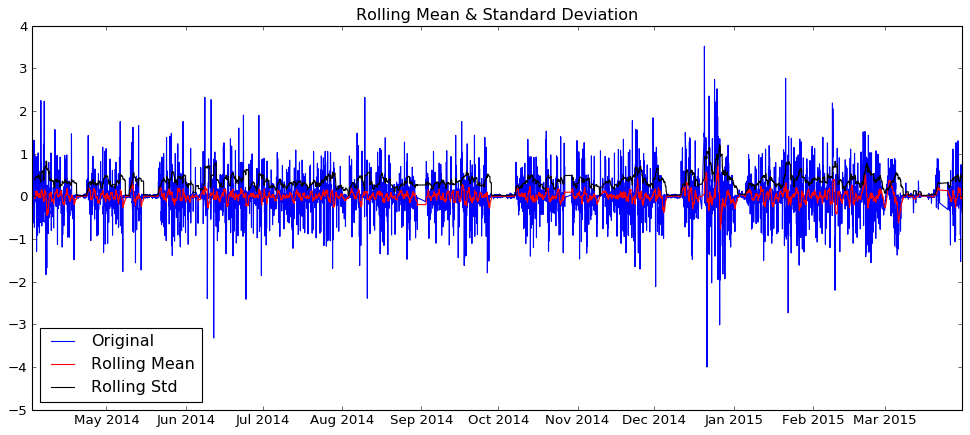

Results of Dickey-Fuller Test:
Test Statistic                -1.784939e+01
p-value                        3.083789e-30
#Lags Used                     3.000000e+01
Number of Observations Used    8.327000e+03
Critical Value (5%)           -2.861887e+00
Critical Value (1%)           -3.431136e+00
Critical Value (10%)          -2.566955e+00
dtype: float64


In [9]:
test_stationarity(data_diff)

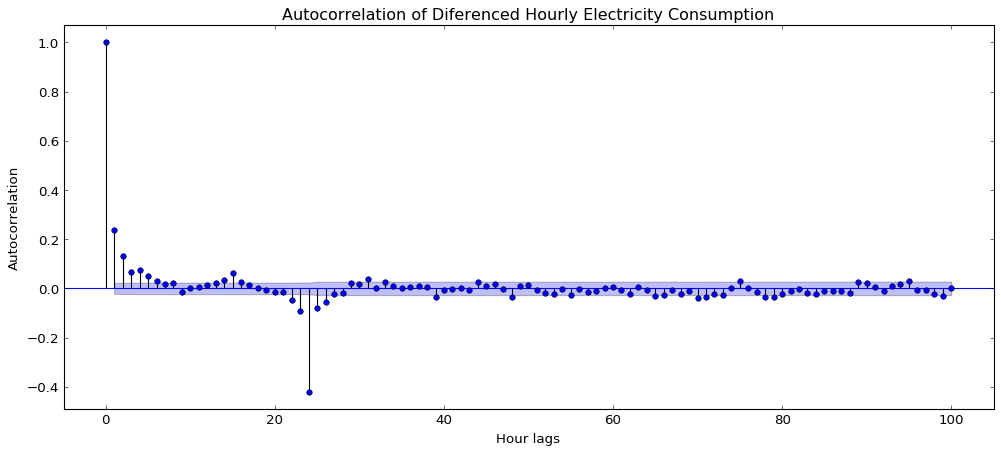

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_diff.House_1,lags=100)
plt.xlabel('Hour lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of Diferenced Hourly Electricity Consumption')
plt.show()

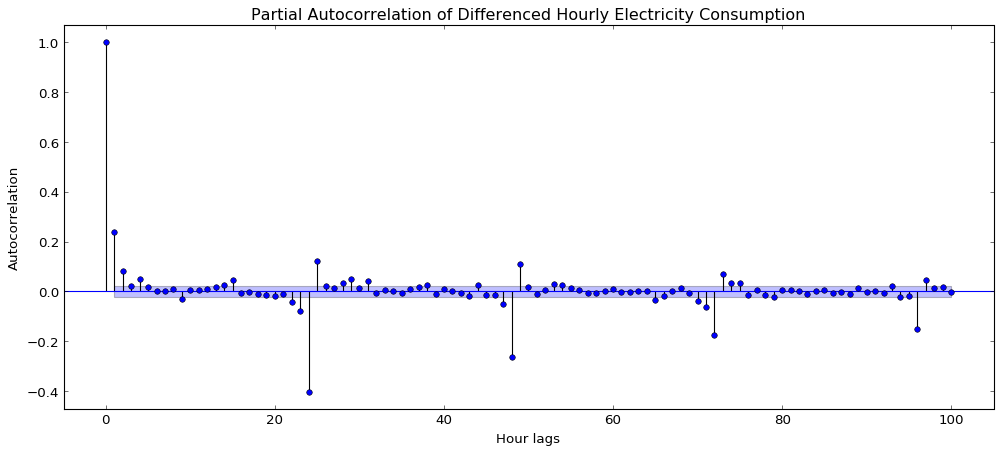

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_diff.House_1,lags=100)
plt.xlabel('Hour lags')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation of Differenced Hourly Electricity Consumption')
plt.show()

The data was differenced on 24 period lags. From the ACF and PACF plots on the differenced data we can determine:
- __Non-Seasonal terms__: AR(1) term from the first (1,2,3..) lags of the PACF plot and MA(1) or MA(2) term from the ACF plot.
- __Seasonal terms__:  PACF plots clear seasonality on $S=24$ hour period and AR(1) term, whereas the ACF plot shoes no sign of seasonal MA terms

In [34]:
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(1, 0, 4),
                                seasonal_order=(1, 0, 1, 24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [35]:
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                            House_1   No. Observations:                 8524
Model:             SARIMAX(1, 0, 4)x(1, 0, 1, 24)   Log Likelihood               -1584.685
Date:                            Fri, 23 Jun 2017   AIC                           3185.370
Time:                                    19:27:31   BIC                           3241.775
Sample:                                04-01-2014   HQIC                          3204.615
                                     - 03-31-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9968      0.001    947.604      0.000       0.995       0.999
ma.L1         -0.6961      0.006   

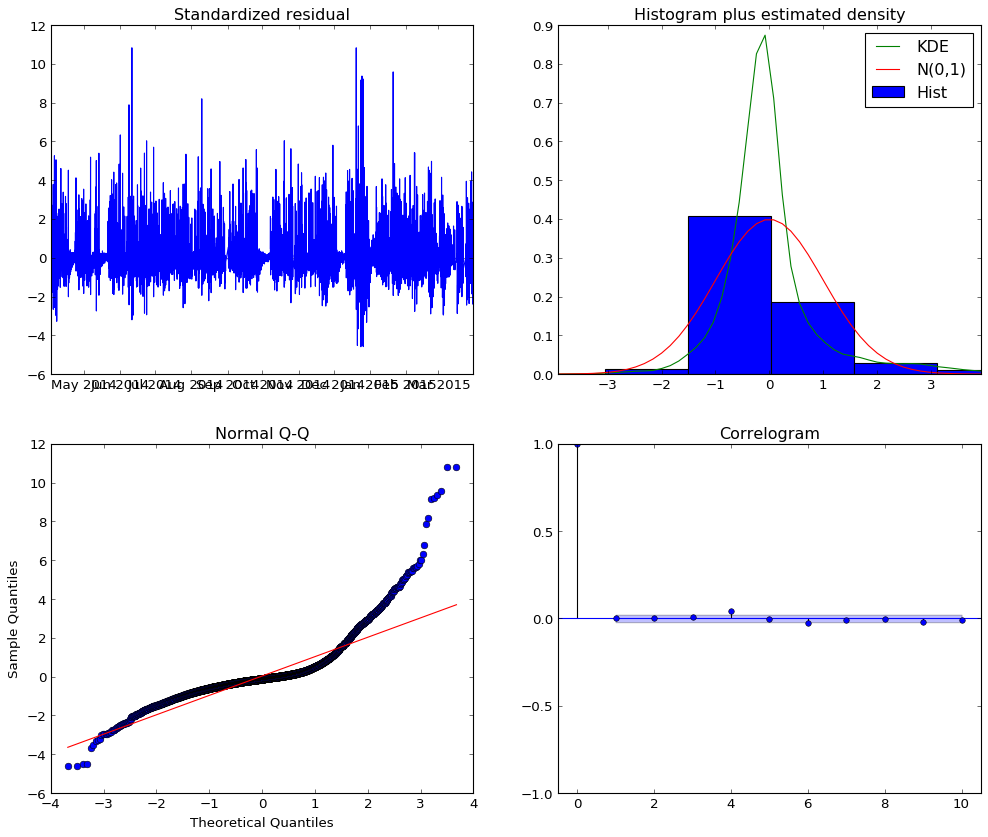

In [36]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [92]:
pred = results.get_prediction(start=pd.to_datetime('2015-03'), dynamic=False)
pred_ci = pred.conf_int()

In [93]:
y_forecasted = pred.predicted_mean
y_truth = data['2015-03':]

# Compute the mean square error
mse = mean_squared_error(y_true=y_truth,y_pred=y_forecasted)
mae = mean_absolute_error(y_true=y_truth,y_pred=y_forecasted)
mde = median_absolute_error(y_true=y_truth,y_pred=y_forecasted)
print('On testing time over two month period the model achieves:')
print('MSE: {0:.3f}, MAE: {1:.3f}, MDE: {2:.3f} '.format(mse,mae,mde))

On testing time over two month period the model achieves:
MSE: 0.076, MAE: 0.186, MDE: 0.098 


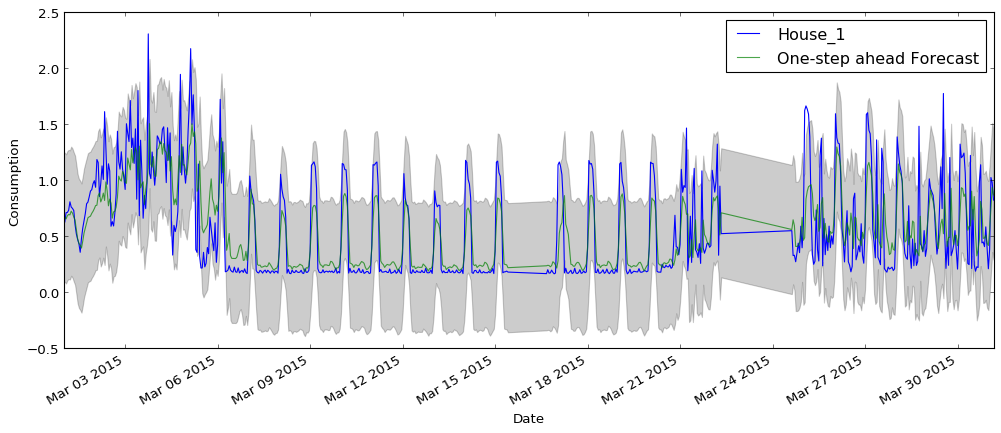

In [94]:
ax = data['2015-03':].plot(label='Observed data')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.legend()

plt.show()

#### Point-to-point predictions

In [46]:
pred = results.get_prediction(start=pd.to_datetime('2015-03'), dynamic=False)
pred_ci = pred.conf_int()

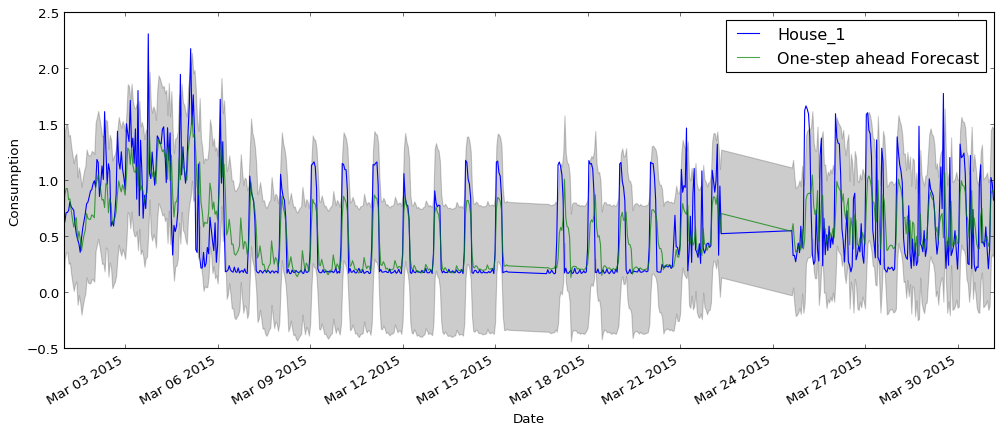

In [47]:
ax = data['2015-03':].plot(label='Observed data')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')
plt.legend()

plt.show()

In [49]:
y_forecasted = pred.predicted_mean
y_truth = data['2015-03':]

# Compute the mean square error
mse = mean_squared_error(y_true=y_truth,y_pred=y_forecasted)
mae = mean_absolute_error(y_true=y_truth,y_pred=y_forecasted)
mde = median_absolute_error(y_true=y_truth,y_pred=y_forecasted)
print('On testing time over two month period the model achieves:')
print('MSE: {0:.3f}, MAE: {1:.3f}, MDE: {2:.3f} '.format(mse,mae,mde))

On testing time over two month period the model achieves:
MSE: 0.085, MAE: 0.199, MDE: 0.126 


#### Dynamic predictions

In [50]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-03'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

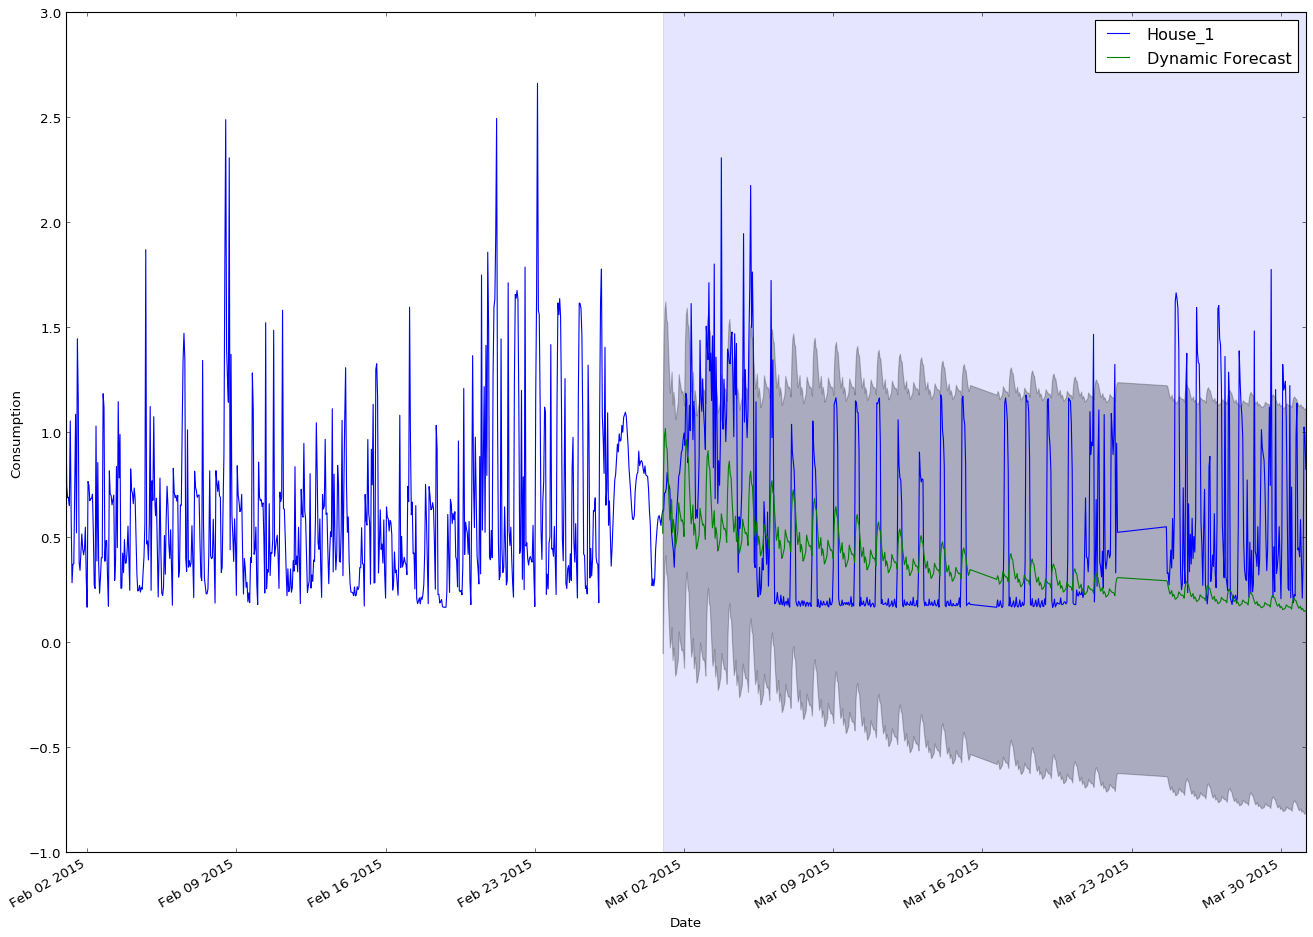

In [54]:
ax = data['2015-02':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-03'), data.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Consumption')

plt.legend()
plt.show()

In [53]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = data['2015-03':]

# Compute the mean square error
mse = mean_squared_error(y_true=y_truth,y_pred=y_forecasted)
mae = mean_absolute_error(y_true=y_truth,y_pred=y_forecasted)
mde = median_absolute_error(y_true=y_truth,y_pred=y_forecasted)
print('On testing time over two month period the model achieves:')
print('MSE: {0:.3f}, MAE: {1:.3f}, MDE: {2:.3f} '.format(mse,mae,mde))

On testing time over two month period the model achieves:
MSE: 0.214, MAE: 0.340, MDE: 0.221 
